* 本例展示如何在alpha-mind中使用机器学习模型

* 请在环境变量中设置`DB_URI`指向数据库

In [1]:
%matplotlib inline

import os
import datetime as dt
import numpy as np
import pandas as pd
from alphamind.api import *
from PyFin.api import *

## 数据配置
------------

In [2]:
freq = '60b'
universe = Universe('custom', ['zz800'])
batch = 1
neutralized_risk = industry_styles
risk_model = 'short'
pre_process = [winsorize_normal, standardize]
post_process = [standardize]
warm_start = 3
data_source = os.environ['DB_URI']
horizon = map_freq(freq)

engine = SqlEngine(data_source)

我们使用当期的`roe_q`因子，来尝试预测未来大概一个月以后的`roe_q`因子。

* 训练的股票池为`zz800`;；
* 因子都经过中性化以及标准化等预处理；
* 对于线性模型，我们以20个工作日为一个时间间隔，用过去4期的数据作为训练用特征。

In [3]:
fit_intercept = True
kernal_feature = 'roe_q'
regress_features = {kernal_feature: LAST(kernal_feature),
                    kernal_feature + '_l1': SHIFT(kernal_feature, 1),
                    kernal_feature + '_l2': SHIFT(kernal_feature, 2),
                    kernal_feature + '_l3': SHIFT(kernal_feature, 3)
                   }
const_features = {kernal_feature: LAST(kernal_feature)}
fit_target = [kernal_feature]

data_meta = DataMeta(freq=freq,
                     universe=universe,
                     batch=batch,
                     neutralized_risk=neutralized_risk,
                     risk_model=risk_model,
                     pre_process=pre_process,
                     post_process=post_process,
                     warm_start=warm_start,
                     data_source=data_source)

alpha_model = LinearRegression(features=regress_features, fit_intercept=True, fit_target=fit_target)
composer = Composer(alpha_model=alpha_model, data_meta=data_meta)

start_date = '2011-01-01'
end_date = '2018-01-01'

## 指标与时间序列相关性分析
--------------

在本段中，我们要尝试回答如下的问题：**对于考察的指标，是当期指标与下期指标哪个对于下期收益的预测性更好？**

这里，假设下期日期为`T`，考察周期为`M`，则：

* 当期指标为，`T - M`时的指标值；
* 下期指标为，`T`时的指标值；
* 下期收益为，`T - M`至`T`时的区间收益；
* 我们同时检验了下期数据与当期数据差值与下期收益的相关性。

In [4]:
data_package1 = fetch_data_package(engine,
                                   alpha_factors=[kernal_feature],
                                   start_date=start_date,
                                   end_date=end_date,
                                   frequency=freq,
                                   universe=universe,
                                   benchmark=906,
                                   warm_start=warm_start,
                                   batch=batch,
                                   neutralized_risk=neutralized_risk,
                                   pre_process=pre_process,
                                   post_process=post_process,
                                   fit_target=fit_target)

2018-05-05 14:00:27,215 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-05-05 14:00:29,623 - ALPHA_MIND - INFO - factor data loading finished
2018-05-05 14:00:32,271 - ALPHA_MIND - INFO - fit target data loading finished
2018-05-05 14:00:36,819 - ALPHA_MIND - INFO - industry data loading finished
2018-05-05 14:00:38,193 - ALPHA_MIND - INFO - benchmark data loading finished
2018-05-05 14:00:44,173 - ALPHA_MIND - INFO - data merging finished
2018-05-05 14:00:44,449 - ALPHA_MIND - INFO - Loading data is finished
2018-05-05 14:00:44,624 - ALPHA_MIND - INFO - Data processing is finished


In [5]:
t_m_factor = data_package1['predict']['x']
t_factor = data_package1['predict']['y']
codes_list1 = data_package1['predict']['code']

In [6]:
data_package2 = fetch_data_package(engine,
                                   alpha_factors=[kernal_feature],
                                   start_date=start_date,
                                   end_date=end_date,
                                   frequency=freq,
                                   universe=universe,
                                   benchmark=906,
                                   warm_start=warm_start,
                                   batch=1,
                                   neutralized_risk=neutralized_risk,
                                   pre_process=pre_process,
                                   post_process=post_process)

2018-05-05 14:00:49,320 - ALPHA_MIND - INFO - Starting data package fetching ...
2018-05-05 14:00:50,281 - ALPHA_MIND - INFO - factor data loading finished
2018-05-05 14:02:09,314 - ALPHA_MIND - INFO - fit target data loading finished
2018-05-05 14:02:09,570 - ALPHA_MIND - INFO - industry data loading finished
2018-05-05 14:02:09,700 - ALPHA_MIND - INFO - benchmark data loading finished
2018-05-05 14:02:11,229 - ALPHA_MIND - INFO - data merging finished
2018-05-05 14:02:11,486 - ALPHA_MIND - INFO - Loading data is finished
2018-05-05 14:02:11,553 - ALPHA_MIND - INFO - Data processing is finished


In [7]:
t_return = data_package2['predict']['y']
codes_list2 = data_package2['predict']['code']

In [8]:
total_data = pd.DataFrame(columns=['dx', 'T-M', 'T', 'Δ'])

for key in t_m_factor.keys():
    t_m = t_m_factor[key].values.flatten()
    t = t_factor[key].flatten()
    ret = t_return[key].flatten()
    
    df1 = pd.DataFrame({'T-M': t_m, 'T': t}, index=codes_list1[key])
    df2 = pd.DataFrame({'dx': ret}, index=codes_list2[key])
    
    df = pd.merge(df1, df2, left_index=True, right_index=True)
    df['Δ'] = df['T'] - df['T-M']
    total_data.loc[key, ['dx', 'T-M', 'T', 'Δ']] = df.corr().loc['dx'][['dx', 'T-M', 'T', 'Δ']]

In [9]:
total_data.mean()

dx     1.000000
T-M    0.051985
T      0.122122
Δ      0.076031
dtype: float64

## 模型预测
-----------

In [10]:
ref_date = '2017-01-31'
ref_date = adjustDateByCalendar('china.sse', ref_date).strftime('%Y-%m-%d')
composer.train(ref_date)

In [11]:
print("Testing IC: {0:.4f}".format(composer.ic(ref_date=ref_date)))

Testing IC: 0.5464


## 模型对比 （线性回归模型 v.s. Naive - 常数线性模型）
------------------

In [12]:
const_model = ConstLinearModel(features=const_features, weights={kernal_feature: 1.}, fit_target=fit_target)
regression_model = LinearRegression(features=regress_features, fit_intercept=fit_intercept, fit_target=fit_target)

const_composer = Composer(alpha_model=const_model, data_meta=data_meta)
regression_composer = Composer(alpha_model=regression_model, data_meta=data_meta)

In [13]:
const_composer.train(ref_date)
regression_composer.train(ref_date)

In [14]:
print("\nConst. Testing IC: {0:.4f}".format(const_composer.ic(ref_date=ref_date)))
print("Regression Testing IC: {0:.4f}".format(regression_composer.ic(ref_date=ref_date)))


Const. Testing IC: 0.5529
Regression Testing IC: 0.5464


## 模型时间序列
-------------------------

通过比较在测试集的结果，我们观察如下两个模型的表现：

* Naive Model：简单的使用因子上期值作为当期值的预测；
* 线性回归模型：利用过去四期的因子值回归后得到模型，然后用这个模型预测当期值；

In [15]:
model_dates = [d.strftime('%Y-%m-%d') for d in list(data_package2['predict']['x'].keys())]

model_df = pd.DataFrame(columns=['naive', 'regress', 'naive ic.', 'regress ic.'])

for ref_date in model_dates:
    const_composer.train(ref_date)
    regression_composer.train(ref_date)
    
    model_df.loc[ref_date, 'naive'] = const_composer[ref_date]
    model_df.loc[ref_date, 'regress'] = regression_composer[ref_date]
    model_df.loc[ref_date, 'naive ic.'] = const_composer.ic(ref_date=ref_date)
    model_df.loc[ref_date, 'regress ic.'] = regression_composer.ic(ref_date=ref_date)
    print("\n{1} Const. Testing IC: {0:.4f}".format(model_df.loc[ref_date, 'naive ic.'], ref_date))
    print("{1} Regression Testing IC: {0:.4f}".format( model_df.loc[ref_date, 'regress ic.'], ref_date))


2011-01-04 Const. Testing IC: 0.5800
2011-01-04 Regression Testing IC: 0.5802

2011-04-07 Const. Testing IC: 0.4844
2011-04-07 Regression Testing IC: 0.6694

2011-07-04 Const. Testing IC: 0.5862
2011-07-04 Regression Testing IC: 0.6396

2011-09-27 Const. Testing IC: 0.6321
2011-09-27 Regression Testing IC: 0.6784

2011-12-27 Const. Testing IC: 0.6823
2011-12-27 Regression Testing IC: 0.6613

2012-03-29 Const. Testing IC: 0.3676
2012-03-29 Regression Testing IC: 0.4809

2012-06-29 Const. Testing IC: 0.8619
2012-06-29 Regression Testing IC: 0.8502

2012-09-21 Const. Testing IC: 0.6434
2012-09-21 Regression Testing IC: 0.5957

2012-12-21 Const. Testing IC: 0.7544
2012-12-21 Regression Testing IC: 0.7612

2013-03-27 Const. Testing IC: 0.4713
2013-03-27 Regression Testing IC: 0.6270

2013-07-01 Const. Testing IC: 0.6004
2013-07-01 Regression Testing IC: 0.6572

2013-09-25 Const. Testing IC: 0.6586
2013-09-25 Regression Testing IC: 0.6992

2013-12-25 Const. Testing IC: 0.2465
2013-12-25 Reg

In [16]:
model_df[['naive ic.', 'regress ic.']].agg(['mean', 'std'])

,naive ic.,regress ic.
mean,0.617097,0.658524
std,0.172611,0.123526


在这个例子中，线性回归模型的IC值略微高于Naive模型。

## 回测（ simple long short strategy）
--------------------------

In [17]:
industry_name = 'sw_adj'
industry_level = 1

industry_names = industry_list(industry_name, industry_level)
industry_total = engine.fetch_industry_matrix_range(universe, dates=model_dates, category=industry_name, level=industry_level)

In [18]:
rets1 = []
rets2 = []

for i, ref_date in enumerate(model_dates):
    py_ref_date = dt.datetime.strptime(ref_date, '%Y-%m-%d')
    industry_matrix = industry_total[industry_total.trade_date == ref_date]
    dx_returns = pd.DataFrame({'dx': data_package2['predict']['y'][py_ref_date].flatten(),
                               'code': data_package2['predict']['code'][py_ref_date].flatten()})
    
    res = pd.merge(dx_returns, industry_matrix, on=['code']).dropna()
    codes = res.code.values.tolist()
    
    alpha_logger.info('{0} full re-balance: {1}'.format(ref_date, len(codes)))
    
    ## naive model
    
    raw_predict1 = const_composer.predict(ref_date).loc[codes]
    er1 = raw_predict1.fillna(raw_predict1.median()).values
    
    target_pos1, _ = er_portfolio_analysis(er1,
                                           res.industry_name.values,
                                           None,
                                           None,
                                           False,
                                           None,
                                           method='ls')
        
    target_pos1['code'] = codes
    result1 = pd.merge(target_pos1, dx_returns, on=['code'])
    ret1 = result1.weight.values @ (np.exp(result1.dx.values) - 1.)
    rets1.append(np.log(1. + ret1))

    ## regression model
    
    raw_predict2 = regression_composer.predict(ref_date).loc[codes]
    er2 = raw_predict2.fillna(raw_predict2.median()).values
    
    target_pos2, _ = er_portfolio_analysis(er2,
                                           res.industry_name.values,
                                           None,
                                           None,
                                           False,
                                           None,
                                           method='ls')
    
    target_pos2['code'] = codes
    result2 = pd.merge(target_pos2, dx_returns, on=['code'])
    ret2 = result2.weight.values @ (np.exp(result2.dx.values) - 1.)
    rets2.append(np.log(1. + ret2))
    ## perfect forcast
    
    alpha_logger.info('{0} is finished'.format(ref_date))

2018-05-05 14:05:43,938 - ALPHA_MIND - INFO - 2011-01-04 full re-balance: 799
2018-05-05 14:05:46,929 - ALPHA_MIND - INFO - 2011-01-04 is finished
2018-05-05 14:05:46,941 - ALPHA_MIND - INFO - 2011-04-07 full re-balance: 798
2018-05-05 14:05:49,923 - ALPHA_MIND - INFO - 2011-04-07 is finished
2018-05-05 14:05:49,935 - ALPHA_MIND - INFO - 2011-07-04 full re-balance: 798
2018-05-05 14:05:53,094 - ALPHA_MIND - INFO - 2011-07-04 is finished
2018-05-05 14:05:53,106 - ALPHA_MIND - INFO - 2011-09-27 full re-balance: 797
2018-05-05 14:05:56,334 - ALPHA_MIND - INFO - 2011-09-27 is finished
2018-05-05 14:05:56,345 - ALPHA_MIND - INFO - 2011-12-27 full re-balance: 798
2018-05-05 14:05:59,460 - ALPHA_MIND - INFO - 2011-12-27 is finished
2018-05-05 14:05:59,469 - ALPHA_MIND - INFO - 2012-03-29 full re-balance: 796
2018-05-05 14:06:02,529 - ALPHA_MIND - INFO - 2012-03-29 is finished
2018-05-05 14:06:02,538 - ALPHA_MIND - INFO - 2012-06-29 full re-balance: 798
2018-05-05 14:06:05,431 - ALPHA_MIND - I

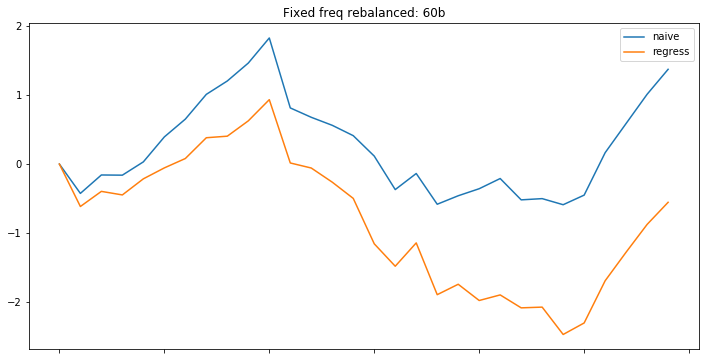

In [19]:
ret_df = pd.DataFrame({'naive': rets1, 'regress': rets2}, index=model_dates)
ret_df.loc[advanceDateByCalendar('china.sse', model_dates[-1], freq).strftime('%Y-%m-%d')] = 0.
ret_df = ret_df.shift(1)
ret_df.iloc[0] = 0.

ret_df[['naive', 'regress']].cumsum().plot(figsize=(12, 6),
                                             title='Fixed freq rebalanced: {0}'.format(freq))